In [1]:
import os
import warnings
import numpy as np
import pandas as pd
from PIL import Image
import tensorflow as tf
import matplotlib.pyplot as plt
from keras.utils import np_utils
from keras.models import load_model
from keras import layers, optimizers 
from keras.preprocessing import image
from keras.models import Sequential, Model
from keras.optimizers import Adam
import keras
from sklearn.model_selection import train_test_split
from keras.layers import Input, GlobalAveragePooling2D, Dense, concatenate, AveragePooling2D
from keras.layers.convolutional import Conv2D
from keras.layers.core import Activation, Dropout
from keras.layers.normalization import BatchNormalization
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint
%matplotlib inline

Using TensorFlow backend.


In [2]:
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/Kannada-MNIST/Dig-MNIST.csv
/kaggle/input/Kannada-MNIST/train.csv
/kaggle/input/Kannada-MNIST/sample_submission.csv
/kaggle/input/Kannada-MNIST/test.csv


In [3]:
config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True
session = tf.compat.v1.Session(config=config)

In [4]:
def plot_history(history):
    history_dict = history.history
    loss_values = history_dict['loss']
    val_loss_values = history_dict['val_loss']
    epochs = range(1, len(loss_values) + 1)

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

    ax1.plot(epochs, loss_values, 'bo',
             label='Training loss')
    ax1.plot(epochs, val_loss_values, 'r',
             label='Validation loss')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Loss')
    ax1.set_xscale('log')

    acc_values = history_dict['accuracy']
    val_acc_values = history_dict['val_accuracy']

    ax2.plot(epochs, acc_values, 'bo',
             label='Training acc')
    ax2.plot(epochs, val_acc_values, 'r',
             label='Validation acc')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Accuracy')
    ax2.set_xscale('log')

    plt.legend()
    plt.show()

In [5]:
test = pd.read_csv("/kaggle/input/Kannada-MNIST/test.csv")
train = pd.read_csv("/kaggle/input/Kannada-MNIST/train.csv")
dig_mnist = pd.read_csv("/kaggle/input/Kannada-MNIST/Dig-MNIST.csv")
sample_submission = pd.read_csv("/kaggle/input/Kannada-MNIST/sample_submission.csv")

In [6]:
print("test.shape", test.shape)
print("train.shape", train.shape)
print("dig_mnist.shape", dig_mnist.shape)
print("sample_submission.shape", sample_submission.shape)

test.shape (5000, 785)
train.shape (60000, 785)
dig_mnist.shape (10240, 785)
sample_submission.shape (5000, 2)


In [7]:
train.head(11)

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,5,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,6,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7,7,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8,8,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [8]:
X_train = train.loc[:, train.columns!='label'].values.astype('uint8')
print("X_train.shape", X_train.shape)
y_train = train['label'].values
X_train = X_train.reshape((X_train.shape[0],28,28))
print("X_train.shape", X_train.shape)
print("y_train.shape",X_train.shape)

X_train.shape (60000, 784)
X_train.shape (60000, 28, 28)
y_train.shape (60000, 28, 28)


In [9]:
test.head(11)

,id,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,5,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,6,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7,7,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8,8,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [10]:
X_test = test.loc[:,  test.columns!='id'].values.astype('uint8')
print("X_test.shape", X_test.shape)
y_id = test['id'].values
X_test = X_test.reshape((X_test.shape[0],28,28))
print("X_test.shape", X_test.shape)
print("y_id.shape", y_id.shape)

X_test.shape (5000, 784)
X_test.shape (5000, 28, 28)
y_id.shape (5000,)


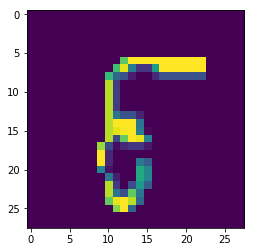

This is a 9


In [11]:
n = np.random.randint(X_train.shape[0])
plt.imshow(Image.fromarray(X_train[n]))
plt.show()
print(f'This is a {y_train[n]}')

In [12]:
X_train = X_train[:,:,:,None]
X_test = X_test[:,:,:,None]

In [13]:
print("X_train.shape", X_train.shape)
print("X_test.shape", X_test.shape)

X_train.shape (60000, 28, 28, 1)
X_test.shape (5000, 28, 28, 1)


In [14]:
batch_size = 32
num_epochs = 50


In [15]:
num_samples = X_train.shape[0]
num_classes = np.unique(y_train).shape[0]
img_rows, img_cols = X_train[0,:,:,0].shape
classes = np.unique(y_train)

In [16]:
print("num_samples",num_samples)
print("num_classes",num_classes)
print("img_rows",img_rows)
print("img_cols",img_cols)
print("classes",classes)

num_samples 60000
num_classes 10
img_rows 28
img_cols 28
classes [0 1 2 3 4 5 6 7 8 9]


In [17]:
y_train = np_utils.to_categorical(y_train, num_classes)
y_train.shape

(60000, 10)

In [18]:
X_train_norm = X_train.astype('float32')
X_test_norm = X_test.astype('float32')
X_train_norm /= 255
X_test_norm /= 255

In [19]:
learning_rate_reduction=ReduceLROnPlateau(monitor='val_loss',
                                          patience=5, 
                                          verbose=1,
                                          factor=0.2
                                         )

In [20]:
early_stopping = EarlyStopping(monitor='val_loss', 
                               mode='min', 
                               verbose=1, 
                               patience=10
                              )

In [21]:
model_check_point = ModelCheckpoint('model.h5', save_best_only=True)

In [22]:
class DenseNet:
    def __init__(self, input_shape=None, dense_blocks=3, dense_layers=-1, growth_rate=12, nb_classes=None,
                 dropout_rate=None, bottleneck=False, compression=1.0, weight_decay=1e-4, depth=40):

        # Checks
        if nb_classes == None:
            raise Exception(
                'Please define number of classes (e.g. num_classes=10). This is required for final softmax.')

        if compression <= 0.0 or compression > 1.0:
            raise Exception('Compression have to be a value between 0.0 and 1.0.')

        if type(dense_layers) is list:
            if len(dense_layers) != dense_blocks:
                raise AssertionError('Number of dense blocks have to be same length to specified layers')
        elif dense_layers == -1:
            dense_layers = int((depth - 4) / 3)
            if bottleneck:
                dense_layers = int(dense_layers / 2)
            dense_layers = [dense_layers for _ in range(dense_blocks)]
        else:
            dense_layers = [dense_layers for _ in range(dense_blocks)]

        self.dense_blocks = dense_blocks
        self.dense_layers = dense_layers
        self.input_shape = input_shape
        self.growth_rate = growth_rate
        self.weight_decay = weight_decay
        self.dropout_rate = dropout_rate
        self.bottleneck = bottleneck
        self.compression = compression
        self.nb_classes = nb_classes
        
    def build_model(self):
        img_input = Input(shape=self.input_shape, name='img_input')
        nb_channels = self.growth_rate
        
        x = Conv2D(2*self.growth_rate, (3,3), 
                   padding='same', strides = (1,1), 
                   kernel_regularizer=keras.regularizers.l2(self.weight_decay))(img_input)
        
        for block in range(self.dense_blocks-1):
            x, nb_channels = self.dense_block(x, self.dense_layers[block], nb_channels, self.growth_rate,
                                              self.dropout_rate, self.bottleneck, self.weight_decay)
            
            x = self.transition_layer(x, nb_channels, self.dropout_rate, self.compression, self.weight_decay)
            nb_channels = int(nb_channels*self.compression)
            
        x, nb_channels = self.dense_block(x, self.dense_layers[-1], nb_channels, self.growth_rate, self.dropout_rate, self.weight_decay)
        
        x = BatchNormalization()(x)
        x = Activation('relu')(x)
        x = GlobalAveragePooling2D()(x)
        prediction = Dense(self.nb_classes, activation='softmax')(x)
        
        return Model(inputs=img_input, outputs=prediction, name='densenet')
        
    def dense_block(self, x, nb_layers, nb_channels, growth_rate, dropout_rate=None, bottleneck=False, weight_decay=1e-4):
        for i in range(nb_layers):
            cb = self.convolution_block(x, growth_rate, dropout_rate, bottleneck)
            nb_channels += growth_rate
            x = concatenate([cb,x])
            
        return x, nb_channels
    
    def convolution_block(self, x, nb_channels, dropout_rate=None, bottleneck=False, weight_decay=1e-4):       

        # Bottleneck
        if bottleneck:
            bottleneckWidth = 4
            x = BatchNormalization()(x)
            x = Activation('relu')(x)
            x = Conv2D(nb_channels * bottleneckWidth, (1, 1),
                                     kernel_regularizer=keras.regularizers.l2(weight_decay))(x)
            # Dropout
            if dropout_rate:
                x = Dropout(dropout_rate)(x)

        # Standard (BN-ReLU-Conv)
        x = BatchNormalization()(x)
        x = Activation('relu')(x)
        x = Conv2D(nb_channels, (3, 3), padding='same')(x)

        # Dropout
        if dropout_rate:
            x = Dropout(dropout_rate)(x)

        return x

    def transition_layer(self, x, nb_channels, dropout_rate=None, compression=1.0, weight_decay=1e-4):
        x = BatchNormalization()(x)
        x = Activation('relu')(x)
        x = Conv2D(int(nb_channels * compression), (1, 1), padding='same',
                                 kernel_regularizer=keras.regularizers.l2(weight_decay))(x)

        # Adding dropout
        if dropout_rate:
            x = Dropout(dropout_rate)(x)

        x = AveragePooling2D((2, 2), strides=(2, 2))(x)
        return x

In [23]:
densenet = DenseNet((28,28,1), nb_classes=10, depth=21)

In [24]:
model = densenet.build_model()
model_optimizer = Adam(lr=1E-3, beta_1=0.9, beta_2=0.999, epsilon=1e-08)
model.compile(loss='categorical_crossentropy', optimizer=model_optimizer, metrics=['accuracy'])
model.summary()

Model: "densenet"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
img_input (InputLayer)          (None, 28, 28, 1)    0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 28, 28, 24)   240         img_input[0][0]                  
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 28, 28, 24)   96          conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 28, 28, 24)   0           batch_normalization_1[0][0]      
___________________________________________________________________________________________

In [25]:
history = model.fit(X_train_norm, 
                     y_train, 
                     batch_size = batch_size,  
                     epochs = num_epochs, 
                     validation_split = 0.1,
                     shuffle = True,
                     callbacks = [learning_rate_reduction, early_stopping]
                    )

Train on 54000 samples, validate on 6000 samples
Epoch 1/50
54000/54000 [==============================] - 799s 15ms/step - loss: 0.1717 - accuracy: 0.9715 - val_loss: 0.2887 - val_accuracy: 0.9243
Epoch 2/50
54000/54000 [==============================] - 779s 14ms/step - loss: 0.0655 - accuracy: 0.9894 - val_loss: 0.0565 - val_accuracy: 0.9910
Epoch 3/50
54000/54000 [==============================] - 783s 15ms/step - loss: 0.0486 - accuracy: 0.9917 - val_loss: 0.1451 - val_accuracy: 0.9643
Epoch 4/50
54000/54000 [==============================] - 792s 15ms/step - loss: 0.0405 - accuracy: 0.9925 - val_loss: 0.2172 - val_accuracy: 0.9228
Epoch 5/50
54000/54000 [==============================] - 786s 15ms/step - loss: 0.0343 - accuracy: 0.9936 - val_loss: 0.0304 - val_accuracy: 0.9947
Epoch 6/50
54000/54000 [==============================] - 785s 15ms/step - loss: 0.0307 - accuracy: 0.9945 - val_loss: 0.0340 - val_accuracy: 0.9923
Epoch 7/50
54000/54000 [==============================] -

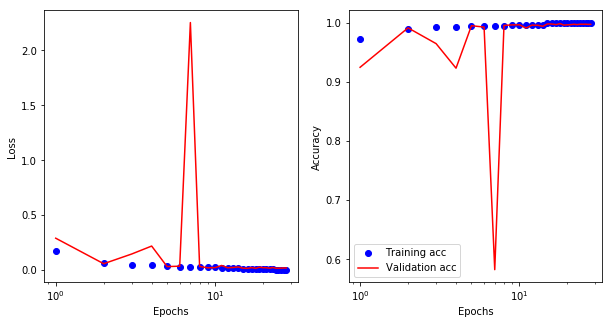

In [26]:
plot_history(history)

In [27]:
model.save('model.h5')

In [28]:
# model = load_model('/kaggle/input/kannada-mnist-simpe-densenet-in-keras-weight/model.h5')

In [29]:
pred = model.predict(X_test_norm)

In [30]:
pred=np.argmax(pred, axis=1)

In [31]:
sample_submission['label'] = pred

In [32]:
sample_submission.head()

,id,label
0,0,3
1,1,0
2,2,2
3,3,6
4,4,7


In [33]:
sample_submission.to_csv("submission.csv", index=False)